## DEEP LEARNING : FRUITS_RECOGNITION WITH CUSTOM NEURAL NETWORK

The goal of the project if to classify fruit images over 81 different classes of fruits. We have several images for train and test sets. For a higher performance of this project, we will use GPU processing instead of CPU. So, we have to check along the project that we have GPU in our system ready to use.

In [1]:
#Importing initial libraries

import numpy as np
import scipy
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' #For prettify plots

#To allow several outputs in the same cell
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

#Checking the available services
import tensorflow as tf
tf.version.VERSION
print("Num GPUs Available: ", tf.config.list_physical_devices())


Num GPUs Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### SOME PLOTS TO SEE THE RESOLUTION OF IMAGES


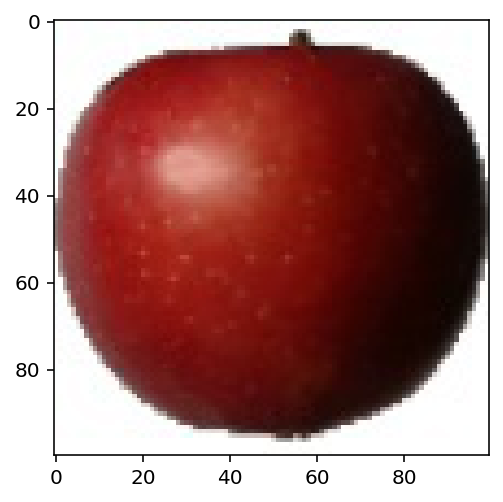

In [2]:
#Let´s visualize first a single example of the dataset: 100x100 pixels

images_dir_train = r'D:\fruits-360\Training'
images_dir_test = r'D:\fruits-360\Test'
rel_dir='\Apple Braeburn\\101_100.jpg' 

#absolute dir 
abs_path=images_dir_train+rel_dir

example=mpimg.imread(abs_path)
plt.imshow(example);

### CHECK THE SIZE OF TRAIN AND TEST SETS

In [3]:
import os
train_size=[]
test_size=[]
categories_train=os.listdir(images_dir_train)
categories_test=os.listdir(images_dir_test)

for cat in categories_train:
    train_size.append(len(os.listdir(images_dir_train+'\\'+cat)))
    
for cat in categories_test:
    test_size.append(len(os.listdir(images_dir_test+'\\'+cat)))
    
print('The number of training examples is:', sum(train_size))
print('The number of test examples is:', sum(test_size))

The number of training examples is: 41322
The number of test examples is: 13877


In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15458970592076491016,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3168845824
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17221010680468117849
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 960, pci bus id: 0000:01:00.0, compute capability: 5.2"]

### CHECK THE BALANCE OF CLASSES IN TRAIN AND TEST SETS

It´s is a good practice to check if we are dealing with a balanced or unbalanced dataset. Extremely unbalaced datasets give poor performances when predicting non seen values. We have to avoid this.

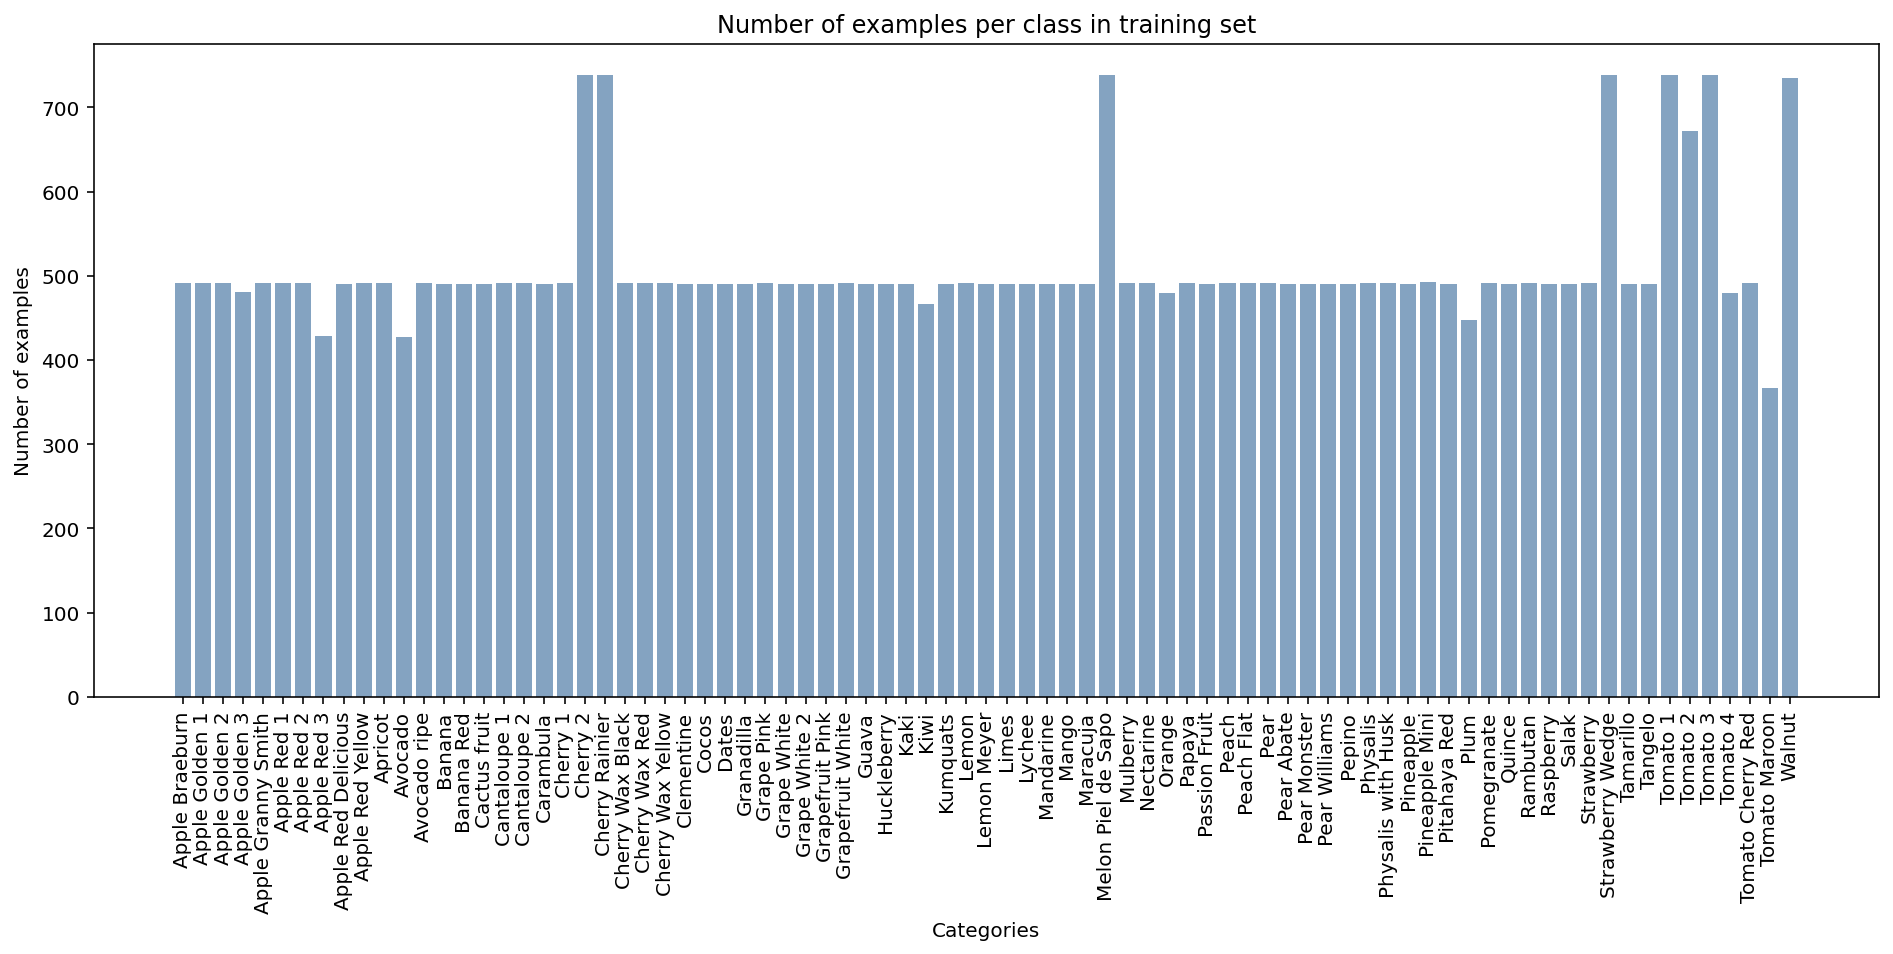

In [13]:
#Distribution of number of examples per class in training set
plt.figure(figsize=(16,6))
plt.bar(x=categories_train,height=train_size, color=(0.2, 0.4, 0.6, 0.6))
plt.xticks(rotation=90)
plt.title('Number of examples per class in training set')
plt.xlabel('Categories')
plt.ylabel('Number of examples');

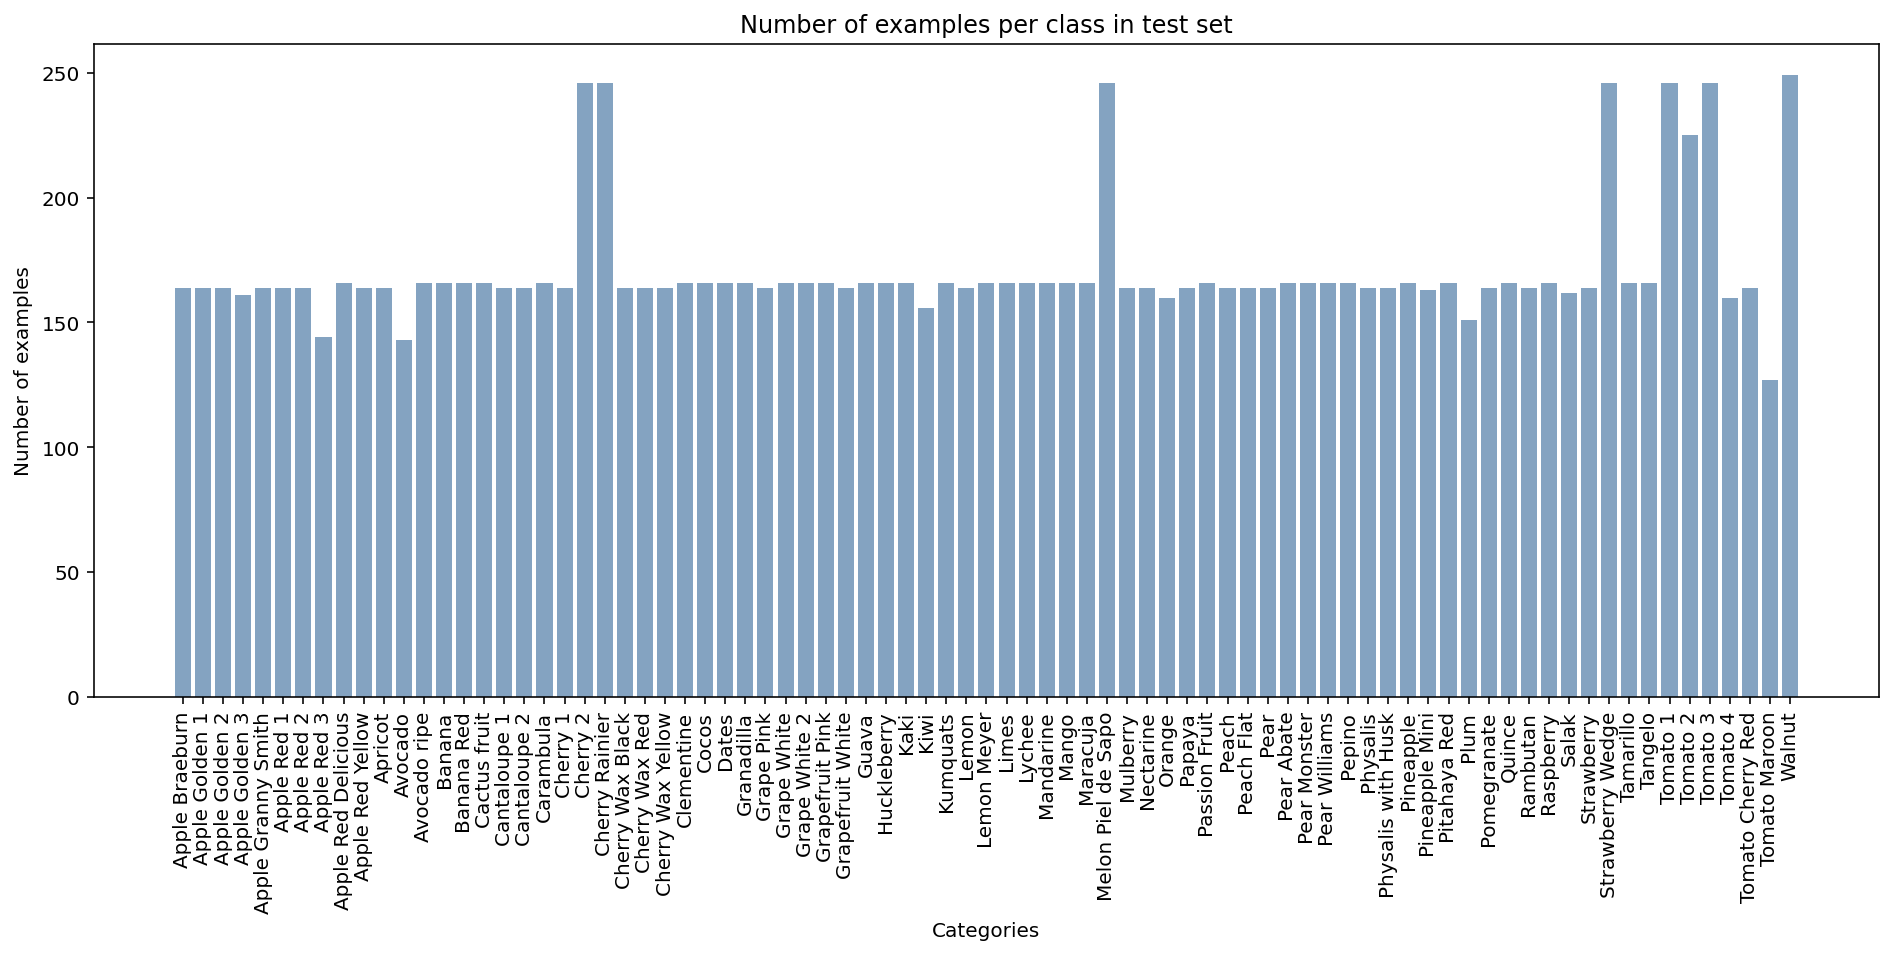

In [15]:
#Distribution of number of examples per class in test set
plt.figure(figsize=(16,6))
plt.bar(x=categories_test,height=test_size, color=(0.2, 0.4, 0.6, 0.6))
plt.xticks(rotation=90)
plt.title('Number of examples per class in test set')
plt.xlabel('Categories')
plt.ylabel('Number of examples');

We can see the same shape in the distribution of examples in train and test set, and the same number of output classes; proportionally the number of examples in train and test sets are distributed in a homogeneus way. We will train a neural network without resampling and without any preprocessing filter to the images. This will be our baseline model. After analyzing the performance of the baseline CNN model we will consider to perform resampling and other preprocessing methods in our images to compare results.

### LOAD THE DATA (BIG DATASET)

When we have a small dataset of images we can load the data using the 'load_files' function from sklearn.datasets. In this case, we have a medium sized dataset, it is big enough for considering using other methods as loading the data in batches, instead of loading all the data at once. We will use the option 'ImageDataGenerator' from Keras. 

We will only perform one preprocessing step that is rescale for optimizing the convergence of the algorithm during training. Also, we will divide the test set into two subsets: One for validation of parameters during training and another one for test the model with unseen values. The proportion will be 50% of the initial test set.

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size=32
epochs=40
train_datagen = ImageDataGenerator(rescale=1. / 255) 
                                    #zoom_range=0.2,
                                    #rotation_range = 5,
                                    #horizontal_flip=True)

test_datagen=   ImageDataGenerator(rescale=1. / 255, validation_split=0.5)

train_generator = train_datagen.flow_from_directory(  
                  images_dir_train,
                  target_size=(100, 100),
                  batch_size=batch_size,
                  class_mode='categorical')

val_generator =  test_datagen.flow_from_directory(  
                 images_dir_test,
                 target_size=(100, 100),
                 batch_size=batch_size,
                 class_mode='categorical',
                 subset='training')

test_generator = test_datagen.flow_from_directory(  
                 images_dir_test,
                 target_size=(100, 100),
                 batch_size=batch_size,
                 class_mode='categorical',
                 subset='validation',
                 shuffle=False)       

#Not shuffling test set makes easier to test the predictions as the filenames are saved in alphabetical order.

Found 41322 images belonging to 81 classes.
Found 6942 images belonging to 81 classes.
Found 6935 images belonging to 81 classes.


### DEFINE AND TRAIN A MODEL

In [5]:
# importing the necessary packages
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate

In [6]:
#Defining the model function

def tensorflow_model():
    
    model=Sequential()
    model.add(Conv2D(filters=16, kernel_size=2, input_shape=(100,100,3), activation= 'relu', padding='same')) #100x100x16                                                                               
    model.add(MaxPooling2D(pool_size=2))   #50x50x16
    
    model.add(Conv2D(filters=32, kernel_size=2, activation= 'relu', padding='same'))  #50x50x32
    model.add(MaxPooling2D(pool_size=2))   #25x25x32
    
    model.add(Conv2D(filters=64, kernel_size=2, activation= 'relu', padding='same')) #25x25x64
    model.add(MaxPooling2D(pool_size=2))   # 12x12x64 
    
    model.add(Conv2D(filters=128, kernel_size=2, activation= 'relu', padding='same')) #12x12x128
    model.add(MaxPooling2D(pool_size=2))   # 6x6x128
    
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(150, activation='relu'))
    model.add(Dropout(0.4))
    
    model.add(Dense(81, activation='softmax'))
    return model

In [7]:
#Creating a model and compiling it

model=tensorflow_model()
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       3

In [20]:
#To verify the default device for training

print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

Default GPU Device:/device:GPU:0


In [8]:
#Defining checkpoints to save work during training (in case of a system failure).

from tensorflow.keras.callbacks import Callback, ModelCheckpoint

filepath=r'D:\fruits-360\trained_weights\epochs\training_weights-{epoch:02d}-{val_accuracy:.3f}.hdf5'

checkpoint=ModelCheckpoint(filepath=filepath,
                           save_weights_only=False,
                           monitor='val_accuracy',
                           mode='max',
                           save_freq='epoch',
                           verbose=1,
                           save_best_only=False)

In [9]:
#Training the model

history=model.fit(train_generator,
                  steps_per_epoch=train_generator.samples//batch_size, 
                  validation_data=val_generator, 
                  validation_steps=val_generator.samples//batch_size, 
                  epochs=epochs,
                  verbose=0,
                  shuffle=True,
                  callbacks=[checkpoint])


  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: saving model to D:\fruits-360\trained_weights\epochs\training_weights-01-0.923.hdf5

Epoch 00002: saving model to D:\fruits-360\trained_weights\epochs\training_weights-02-0.958.hdf5

Epoch 00003: saving model to D:\fruits-360\trained_weights\epochs\training_weights-03-0.971.hdf5

Epoch 00004: saving model to D:\fruits-360\trained_weights\epochs\training_weights-04-0.965.hdf5

Epoch 00005: saving model to D:\fruits-360\trained_weights\epochs\training_weights-05-0.970.hdf5

Epoch 00006: saving model to D:\fruits-360\trained_weights\epochs\training_weights-06-0.972.hdf5

Epoch 00007: saving model to D:\fruits-360\trained_weights\epochs\training_weights-07-0.959.hdf5

Epoch 00008: saving model to D:\fruits-360\trained_weights\epochs\training_weights-08-0.961.hdf5

Epoch 00009: saving model to D:\fruits-360\trained_weights\epochs\training_weights-09-0.962.hdf5

Epoch 00010: saving model to D:\fruits-360\trained_weights\epochs\t

### SAVE THE TRAINED MODEL

In [11]:
#Save the trained model to a file

import h5py
model_weights=r'D:\fruits-360\trained_weights\fruits_25epoch_cnn.h5'
model.save(model_weights)

### PLOT THE MODEL PERFORMANCE

We can plot model accuracy and loss for each epoch, but we have to consider that we are performing 'dropout' to minimize overfitting of the neural network, and with dropout we have a different cost function in each iteration; so when we plot loss for each epoch, we are not comparing all the time the value of the same cost function. Nevertheless, as it has been said, dropout is a method to control overfitting and this contributes to make the model gives almost the same importance to all the variables during training, so we can "suppose" that despite we can observe a non-regular behaviour of losses and accuracy during training, after all we should observe the general behaviour of the learning curves, that is, if they are improving with or not. And the same for the validation set in comparison with train set. Also, during validation of test set dropout is not applied.

In [10]:
scores_train=model.evaluate(train_generator, verbose=1)
scores_validation=model.evaluate(val_generator, verbose=1)

print('Train Accuracy: %.2f%%' % (scores_train[1]*100))
print('Validation Accuracy: %.2f%%' % (scores_validation[1]*100))

  ...
    to  
  ['...']
1292/1292 [==============================] - 26s 20ms/step - loss: 0.0076 - accuracy: 0.9948
  ...
    to  
  ['...']
217/217 [==============================] - 4s 21ms/step - loss: 0.3114 - accuracy: 0.9751
Train Accuracy: 99.48%
Validation Accuracy: 97.51%


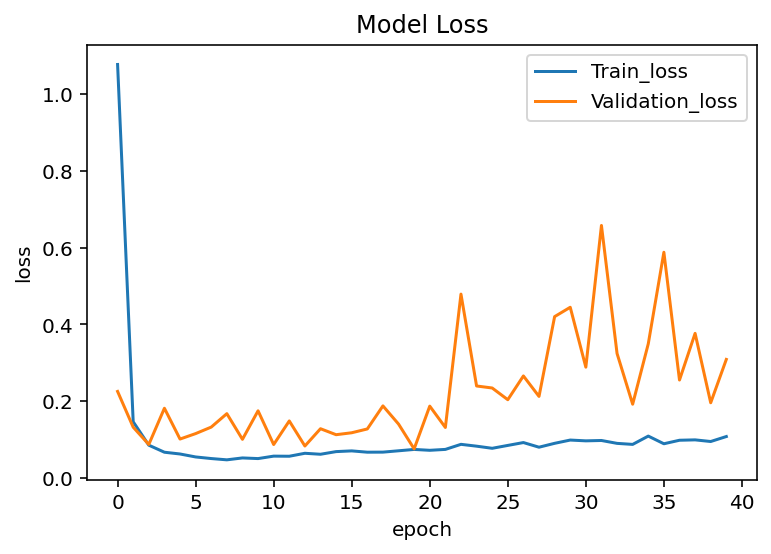

In [11]:
def Loss_curve(history):
    plt.plot(history.history['loss'], label='Train_loss')
    plt.plot(history.history['val_loss'], label='Validation_loss')
    plt.title('Model Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')

Loss_curve(history)


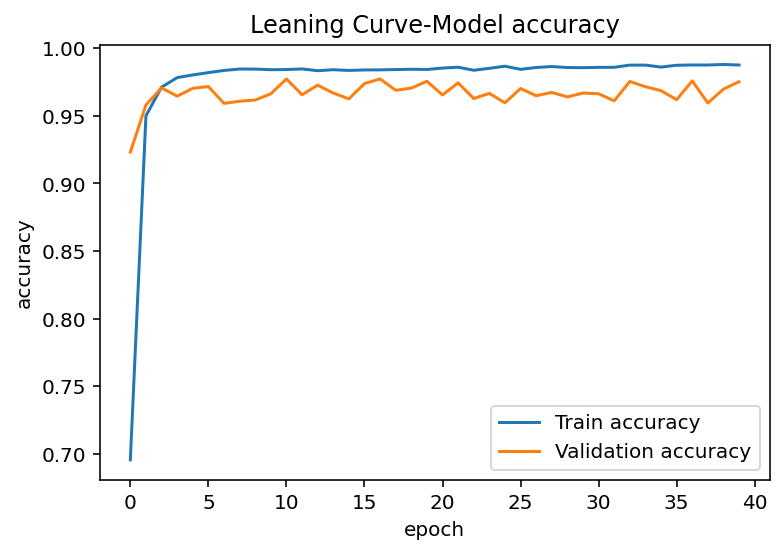

In [12]:
#Plotting Accuracy and Loss Function

def Learning_curve (history):
    plt.plot(history.history['accuracy'], label='Train accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Leaning Curve-Model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='lower right')

Learning_curve(history)


### MAKE PREDICTIONS

In [30]:
#Loading the optimal weights during training step

from tensorflow.keras.models import load_model
optimal_weights=r'D:\fruits-360\trained_weights\epochs\training_weights-16-0.974.hdf5'
final_model=load_model(optimal_weights)
pred=final_model.predict(test_generator, verbose=1, steps=np.math.ceil(test_generator.samples/batch_size)) #Probabilities values
prediction_class=np.argmax(pred, axis=1)                                                 #Integer class value

labels=test_generator.class_indices
labels=list(labels.keys())
pred_class_name=[labels[k] for k in prediction_class]

217/217 [==============================] - 4s 20ms/step


In [31]:
#we test that the generator and the predictions have the same index order, so we can compare and check the results
test_generator.classes
prediction_class

array([ 0,  0,  0, ..., 80, 80, 80])

array([ 0,  0,  0, ..., 80, 80, 80], dtype=int64)

In [32]:
#Score on the test set

scores_test=final_model.evaluate(test_generator, verbose=1)

  ...
    to  
  ['...']
217/217 [==============================] - 5s 21ms/step - loss: 0.0652 - accuracy: 0.9908


### PLOT PREDICTIONS

In [18]:
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix=confusion_matrix(test_generator.classes, prediction_class)
print(conf_matrix)

classif_report=classification_report(test_generator.classes, prediction_class, target_names=labels, output_dict=True)

[[ 82   0   0 ...   0   0   0]
 [  0  81   0 ...   0   0   0]
 [  0   0  82 ...   0   0   0]
 ...
 [  0   0   0 ...  82   0   0]
 [  0   0   0 ...   0  63   0]
 [  0   0   0 ...   0   0 124]]


In [19]:
import pandas as pd
cm=pd.DataFrame(conf_matrix, columns=labels)

In [20]:
cr=pd.DataFrame(classif_report)
cr=cr.T
cr=cr[['precision','recall','f1-score']]

### Plot Confusion Matrix 

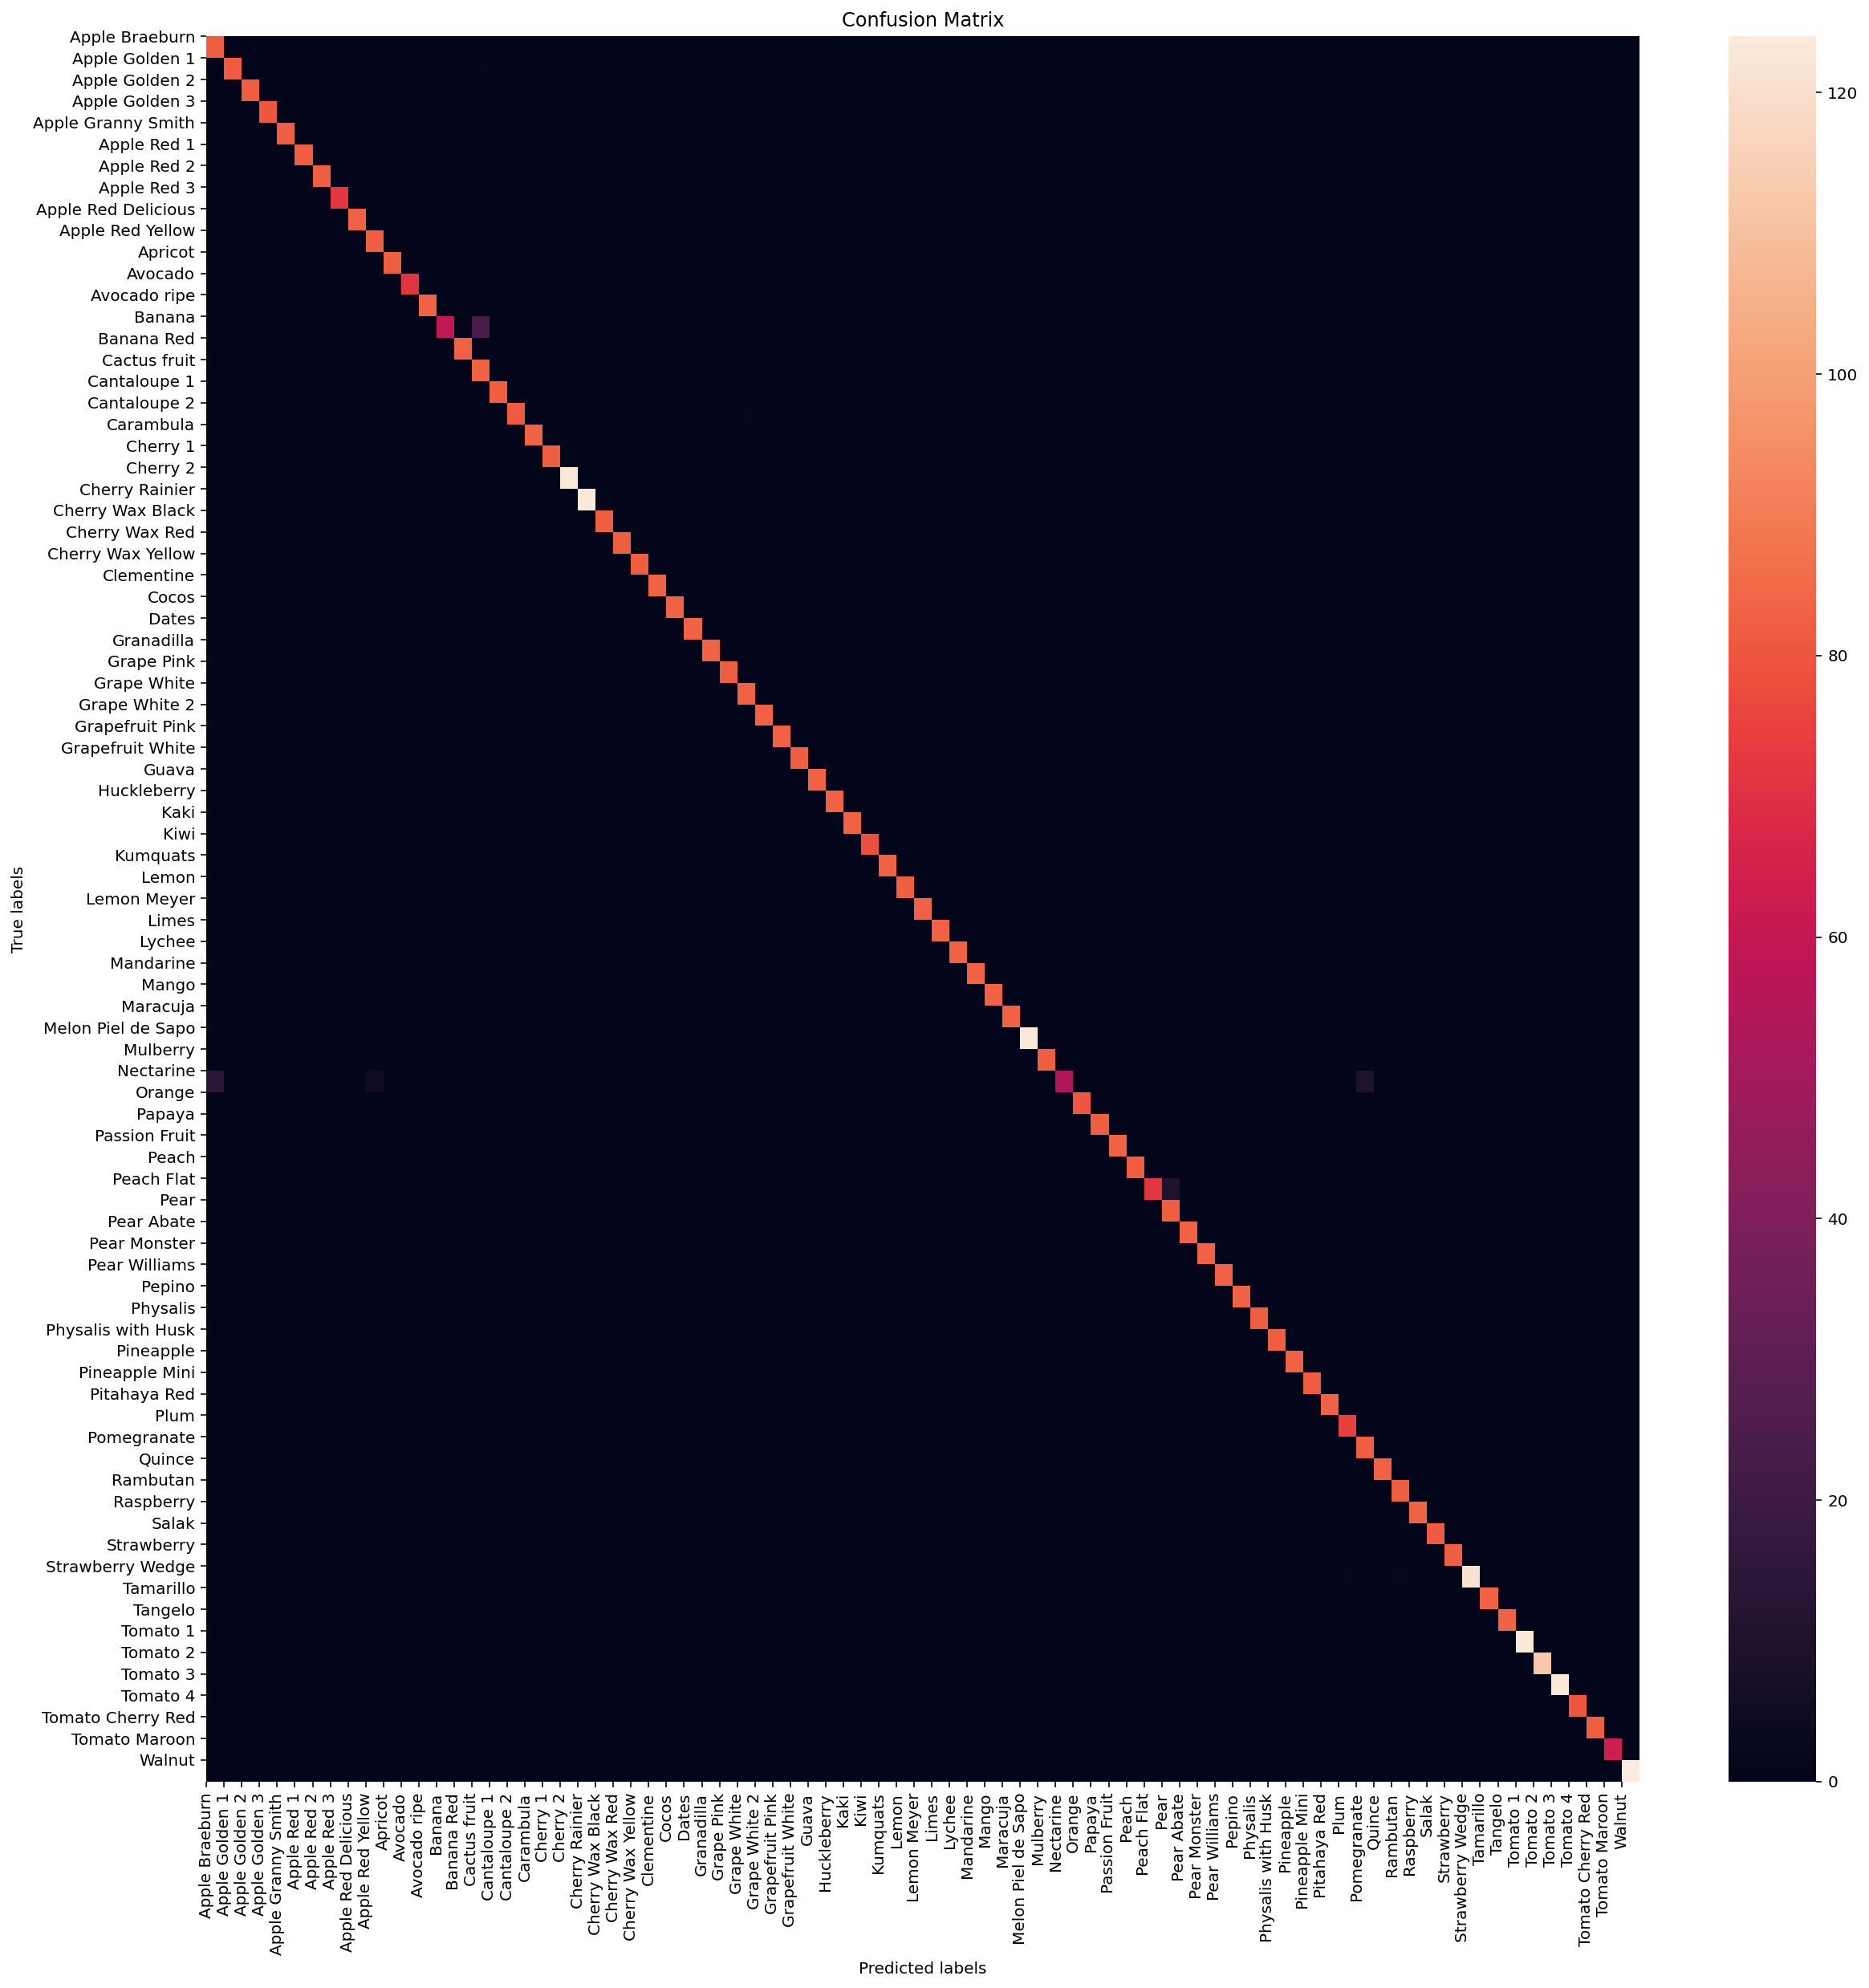

In [33]:
import seaborn as sns

plt.figure(figsize=(20,20))
ax=sns.heatmap(cm)
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
ax.set_yticks([i for i in range(81)])
ax.set_xticks([i for i in range(81)])
ax.set_yticklabels(labels, rotation=0)
ax.set_xticklabels(labels, rotation=90);

### Plot Classification Report

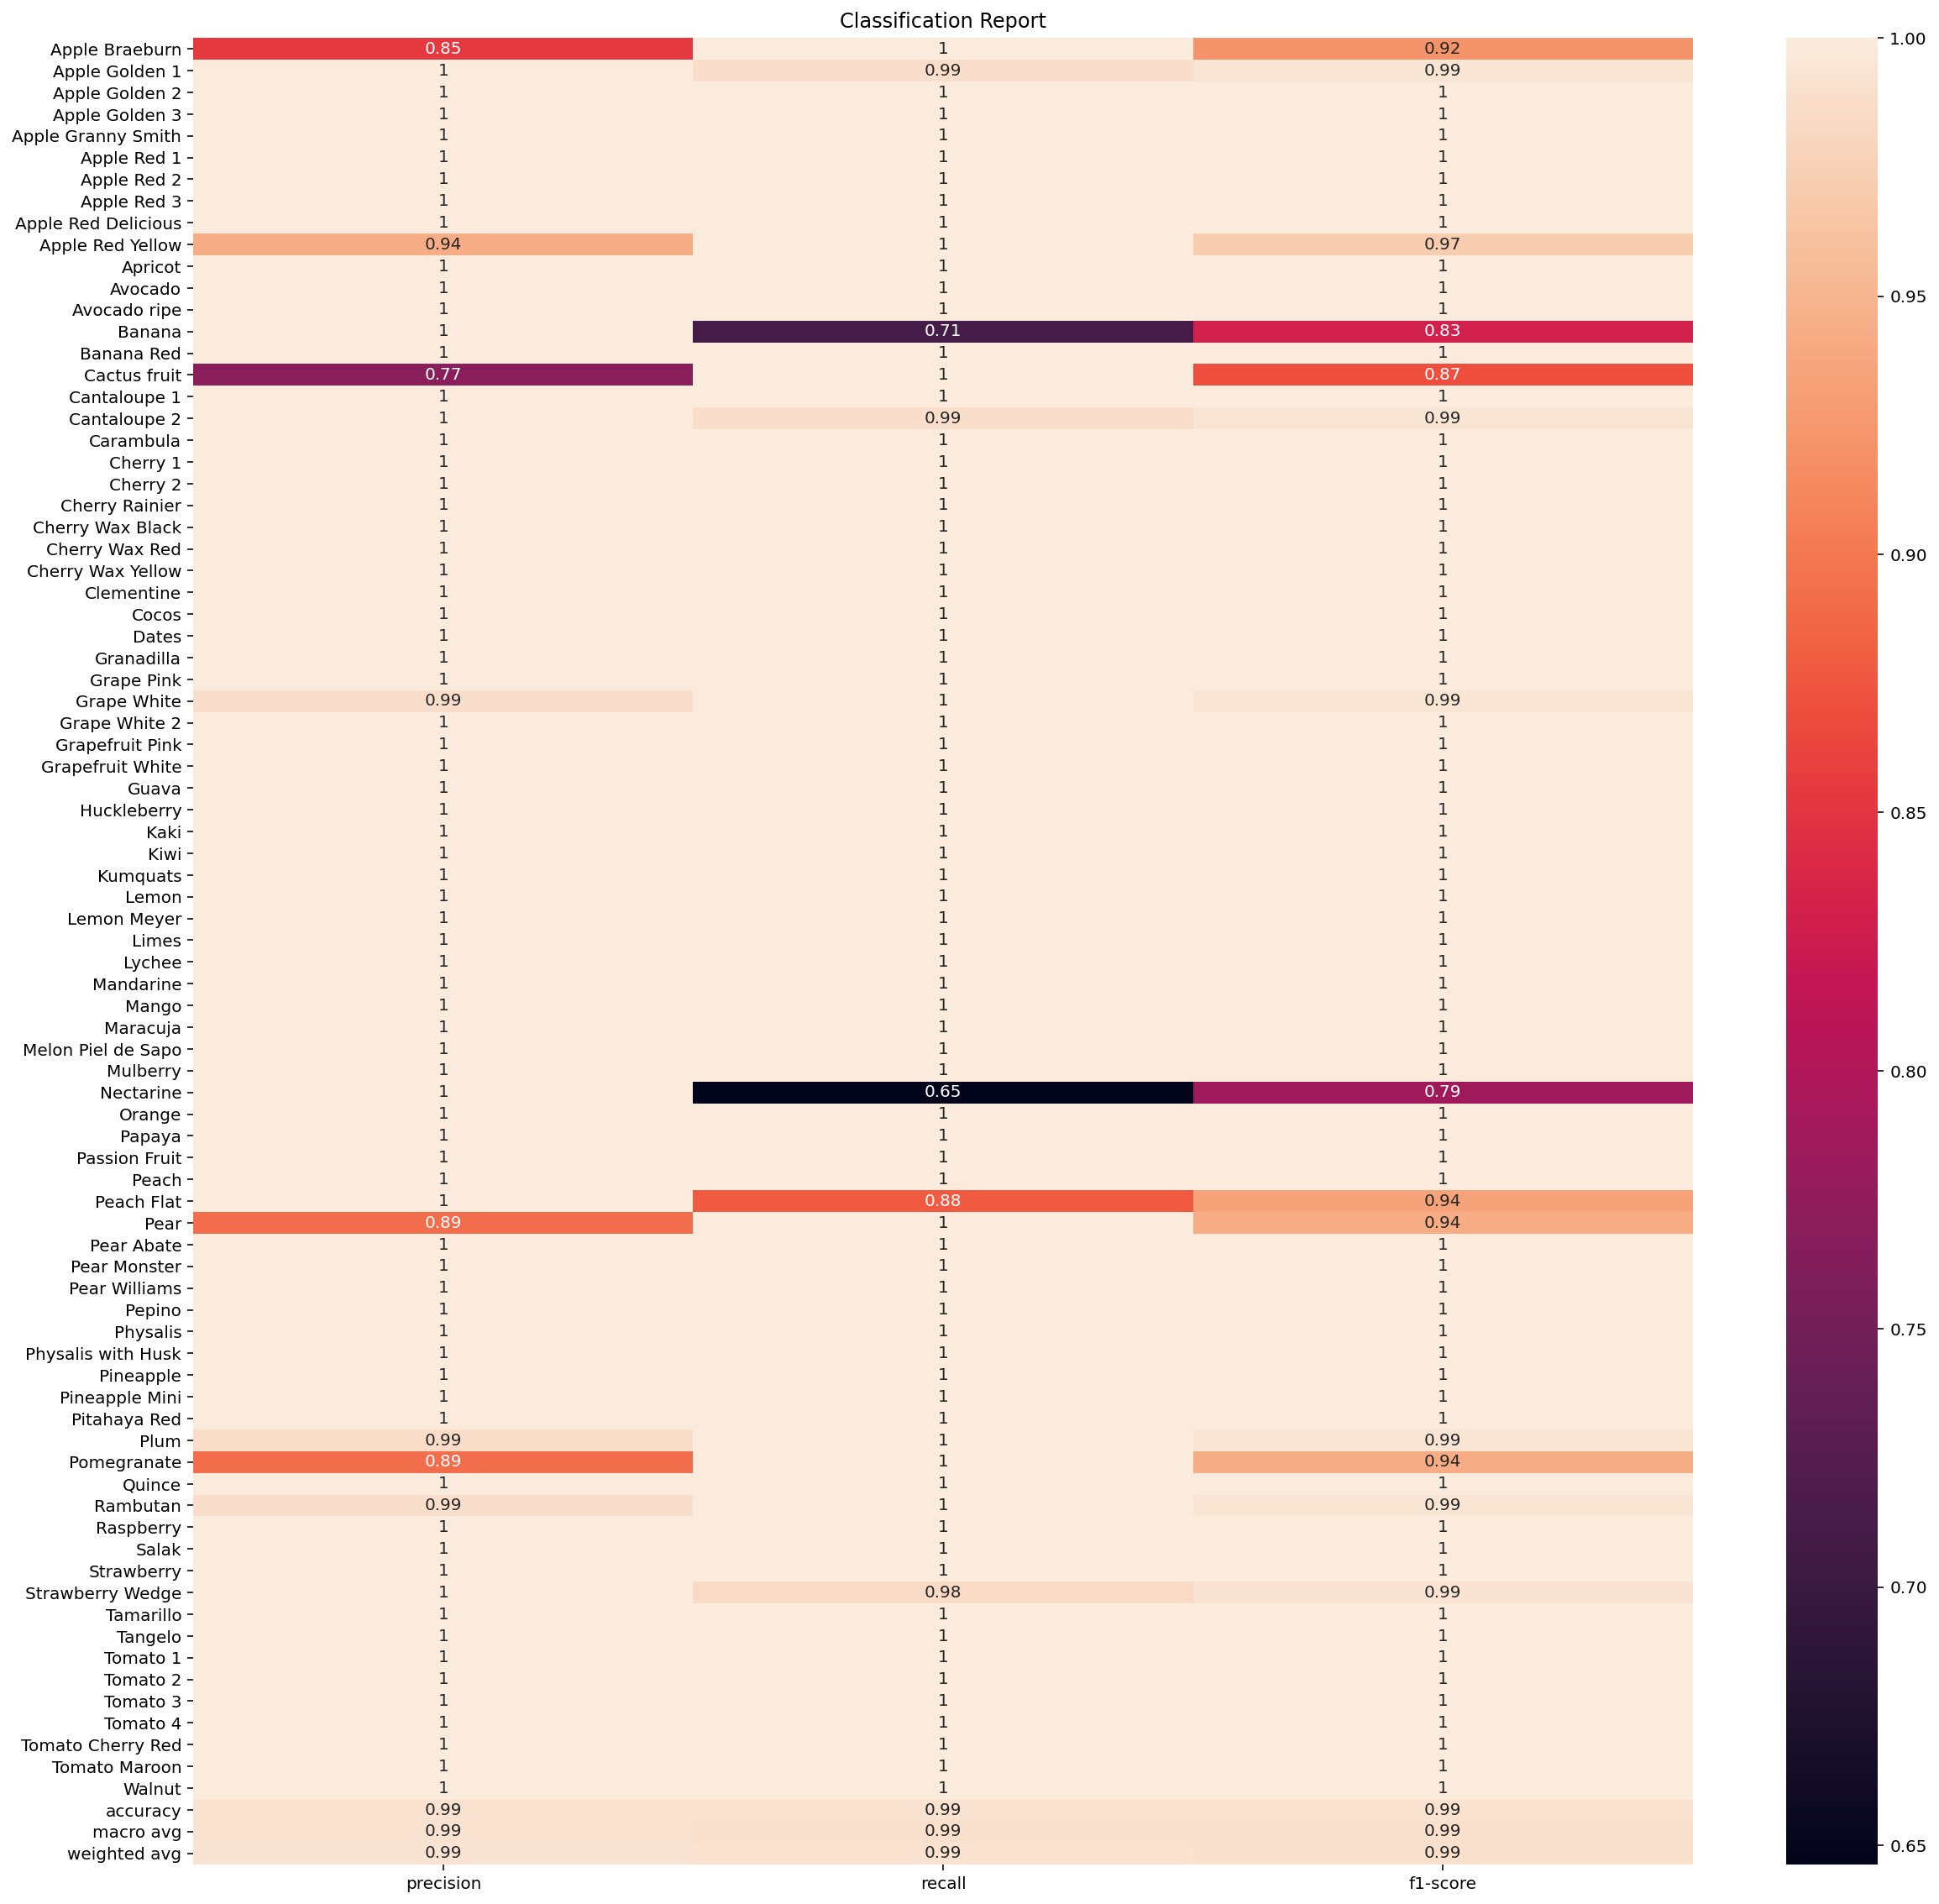

In [34]:
plt.figure(figsize=(20,20))
ax=sns.heatmap(cr, annot=True)
plt.title('Classification Report');

As we can see above, our model has a quite good performance with a 99% of accuracy in test set. However there are some classes for which we would need to improve this performance, for example with "nectarine" and "banana". Perhaps increasing the number of images in training set for this classes we could improve a little bit.